# GLM ROBUST LINEAR REGRESSION

## Load libraries

In [1]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Create toy data

In [3]:
size = 100
true_intercept = 1
true_slope = 2

In [4]:
x = np.linspace(0, 1, size)

In [5]:
# y = a + bx
true_regression_line = true_intercept + true_slope * x

In [7]:
# Add noise
y = true_regression_line + rng.normal(scale = 0.5, size = size)

In [8]:
# Add outliers

In [10]:
x_out = np.append(x, [0.1, 0.15, 0.2])

In [11]:
y_out = np.append(y, [8, 6, 9])

In [14]:
y_out

array([0.88867889, 1.68303139, 0.75491903, 1.39473066, 1.65349859,
       1.39468213, 1.09549048, 0.21889017, 1.00800598, 1.1759379 ,
       1.51973983, 1.27886678, 1.95182238, 1.6623342 , 1.0690385 ,
       2.07037435, 0.20955294, 1.484642  , 0.80286117, 2.03427322,
       1.66041097, 0.89324583, 1.39533186, 1.6592593 , 0.50717011,
       1.67372863, 1.7639667 , 0.99381716, 1.31629944, 2.04375579,
       1.28993484, 1.88798065, 1.83780954, 1.75575422, 1.30895949,
       1.29226358, 2.0002545 , 2.39308081, 2.01608283, 1.16951008,
       1.29369297, 1.63435072, 1.76610935, 1.88265753, 2.63492584,
       1.46268839, 1.72730715, 2.13476023, 2.06080281, 2.66779036,
       2.04311274, 1.4563851 , 2.65366151, 2.21760039, 1.96786625,
       2.54228601, 2.6002637 , 2.17483842, 1.57755531, 1.42900389,
       2.88125529, 2.43039844, 2.38731264, 2.14167826, 2.5670392 ,
       2.79645358, 2.55425072, 2.74726766, 2.37941338, 3.57755595,
       2.47487026, 2.37312525, 2.76132893, 2.99981097, 2.38560

## Plot toy data

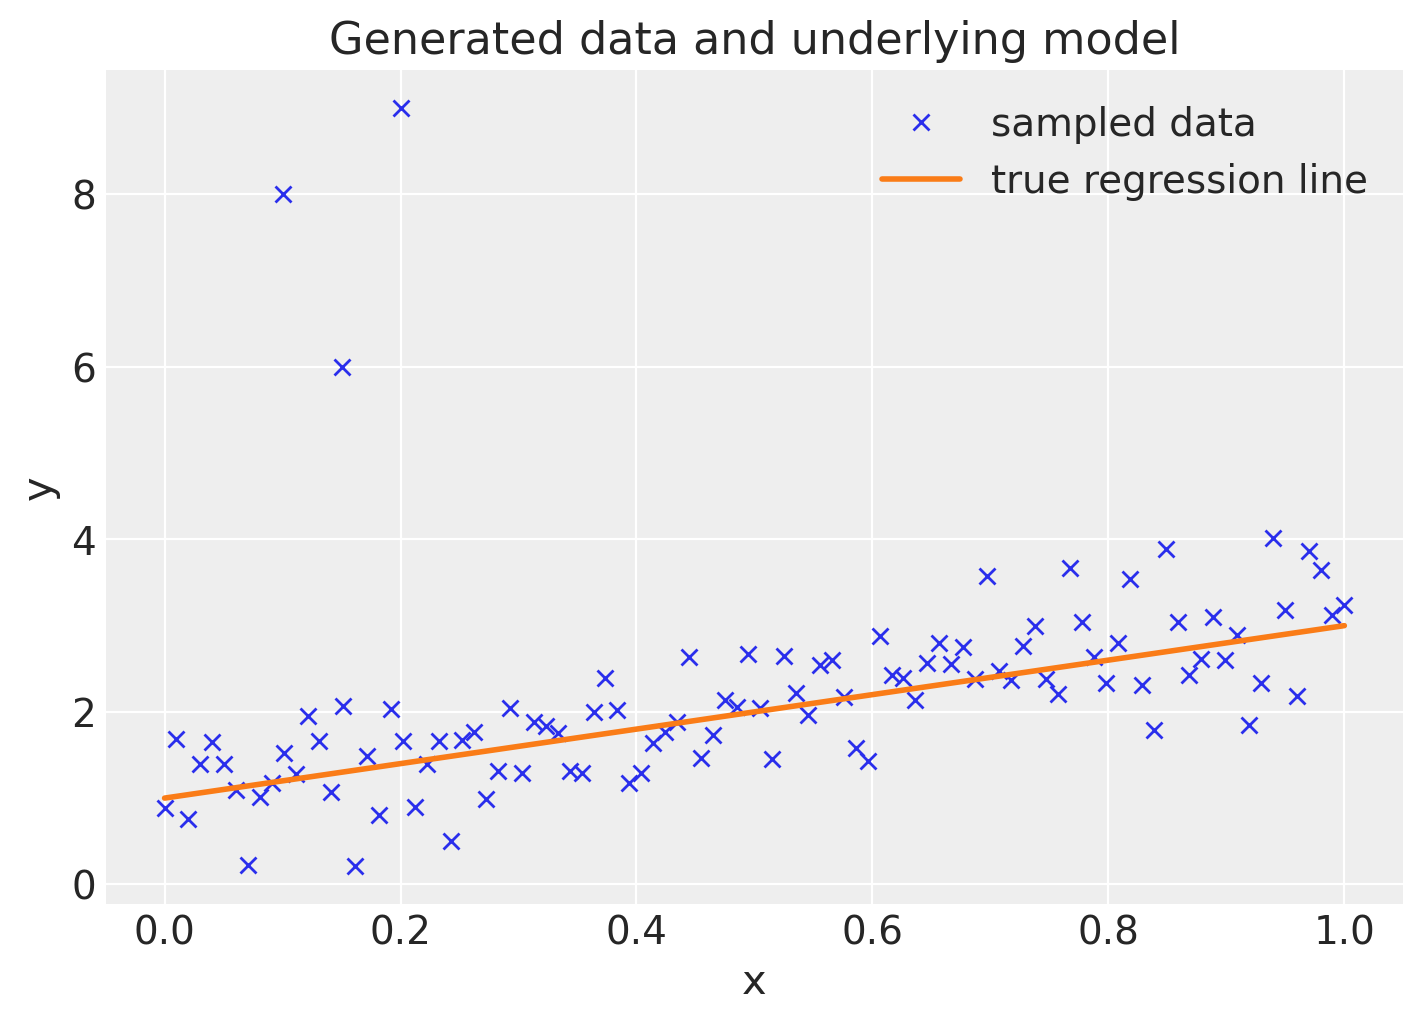

In [12]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Robust regression

### Normal likelyhood

In [23]:
with pm.Model() as model:
    xdata = pm.ConstantData('x', x_out, dims = 'obs_id')
    
    # Define priors
    intercept = pm.Normal('intercept', mu = 0, sigma = 1)
    slope = pm.Normal('slope', mu = 0, sigma = 1)
    sigma = pm.HalfCauchy('sigma', beta = 10)
    
    # Define model    
    mu = pm.Deterministic('mu', intercept + slope * xdata, dims = 'obs_id')
    
    # Define likelyhood
    likelihood = pm.Normal('y', mu = mu, sigma = sigma, observed = y_out, dims = 'obs_id')    

In [17]:
with model:
    trace = pm.sample(tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 31 seconds.


#### Evaluate the fit

In [18]:
post = az.extract(trace, num_samples = 20)

In [20]:
x_plot = xr.DataArray(np.linspace(x_out.min(), x_out.max(), 100), dims="plot_id")
lines = post["intercept"] + post["slope"] * x_plot

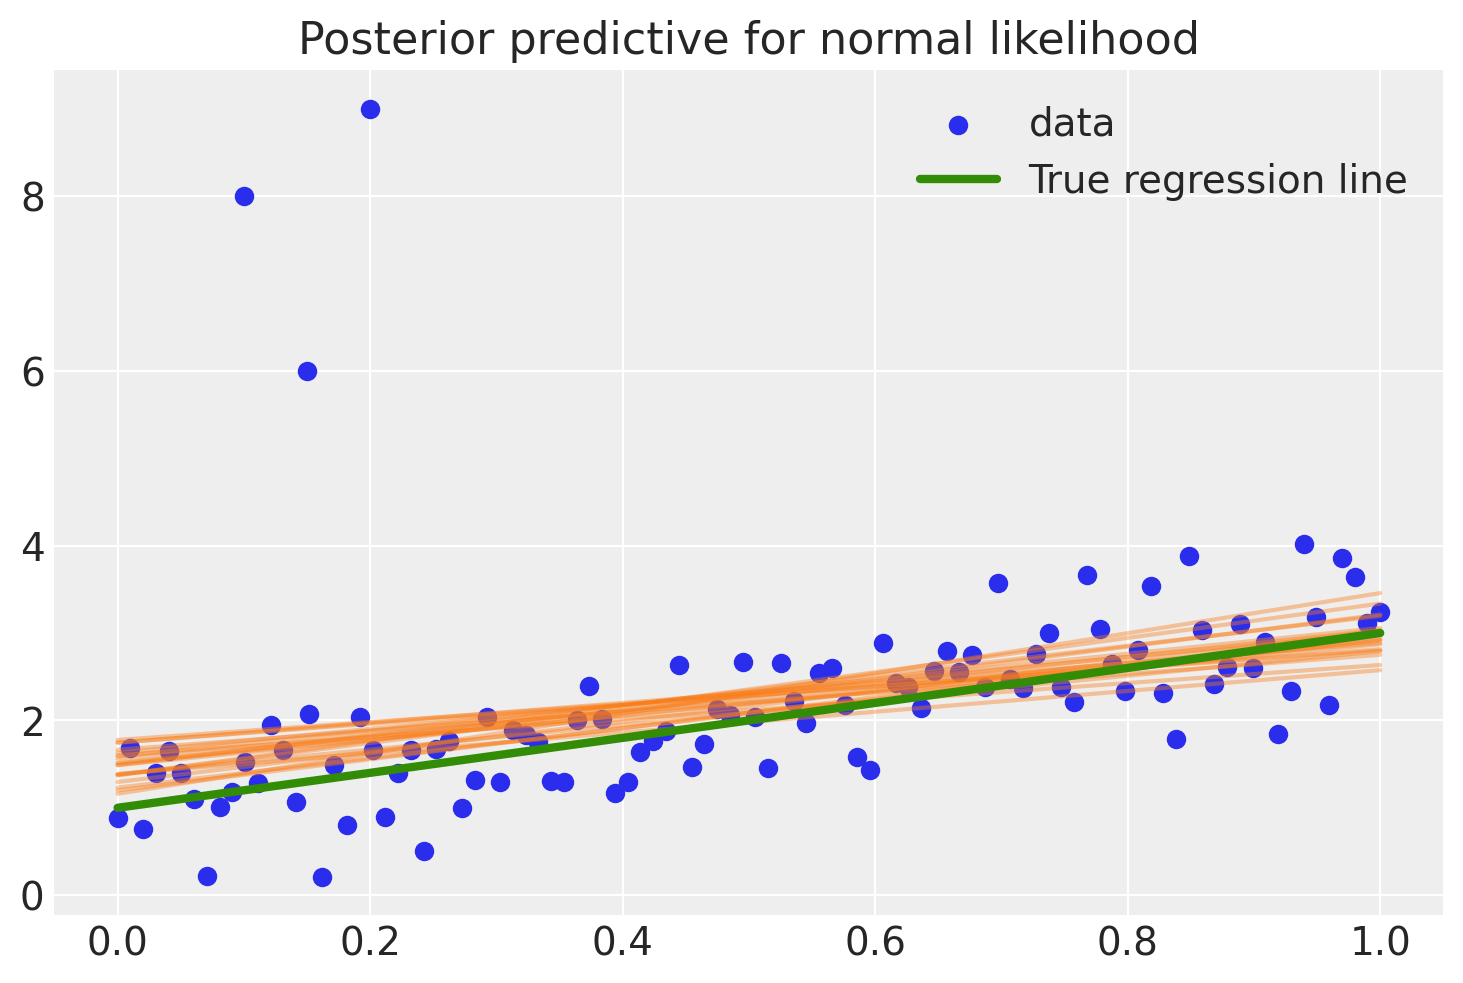

In [21]:
plt.scatter(x_out, y_out, label="data")
plt.plot(x_plot, lines.transpose(), alpha=0.4, color="C1")
plt.plot(x, true_regression_line, label="True regression line", lw=3.0, c="C2")
plt.legend(loc=0)
plt.title("Posterior predictive for normal likelihood");

### Student fit

In [26]:
with pm.Model() as robust_model:
    xdata = pm.ConstantData('x', x_out, dims = 'obs_id')
    
    # Define priors
    intercept = pm.Normal('intercept', mu = 0, sigma = 1)
    slope = pm.Normal('slope', mu = 0, sigma = 1)
    sigma = pm.HalfCauchy('sigma', beta = 10)
    nu = pm.Exponential('nu', scale = 1/29)
    
    # Define model    
    mu = pm.Deterministic('mu', intercept + slope * xdata, dims = 'obs_id')
    
    # Define likelyhood
    likelihood = pm.StudentT('y', mu = mu, sigma = sigma, nu = 3, observed = y_out, dims = 'obs_id')    

In [27]:
with robust_model:
    robust_trace = pm.sample(tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 41 seconds.


In [28]:
robust_post = az.extract(robust_trace, num_samples=20)

In [29]:
robust_post

<xarray.Dataset>
Dimensions:    (sample: 20, obs_id: 103)
Coordinates:
  * obs_id     (obs_id) int32 0 1 2 3 4 5 6 7 8 ... 95 96 97 98 99 100 101 102
  * sample     (sample) object MultiIndex
  * chain      (sample) int32 1 2 2 2 2 1 3 0 0 0 0 0 0 0 3 3 1 1 3 3
  * draw       (sample) int32 393 758 48 191 297 698 ... 570 687 616 84 981 651
Data variables:
    intercept  (sample) float64 1.04 1.06 0.9589 1.151 ... 1.221 1.147 1.036
    slope      (sample) float64 2.223 1.946 2.239 1.871 ... 1.718 1.953 2.094
    sigma      (sample) float64 0.3983 0.4126 0.4461 ... 0.443 0.396 0.3806
    nu         (sample) float64 0.005719 0.04641 0.005157 ... 0.01029 0.01289
    mu         (obs_id, sample) float64 1.04 1.06 0.9589 ... 1.564 1.537 1.455
Attributes:
    created_at:                 2023-11-07T19:52:55.364351
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0
    sampling_time:              41.448487520217896
    tuning_steps:               2000

In [30]:
x_plot = xr.DataArray(np.linspace(x_out.min(), x_out.max(), 100), dims="plot_id")
robust_lines = robust_post["intercept"] + robust_post["slope"] * x_plot

Text(0.5, 1.0, 'Posterior predictive for Student-T likelihood')

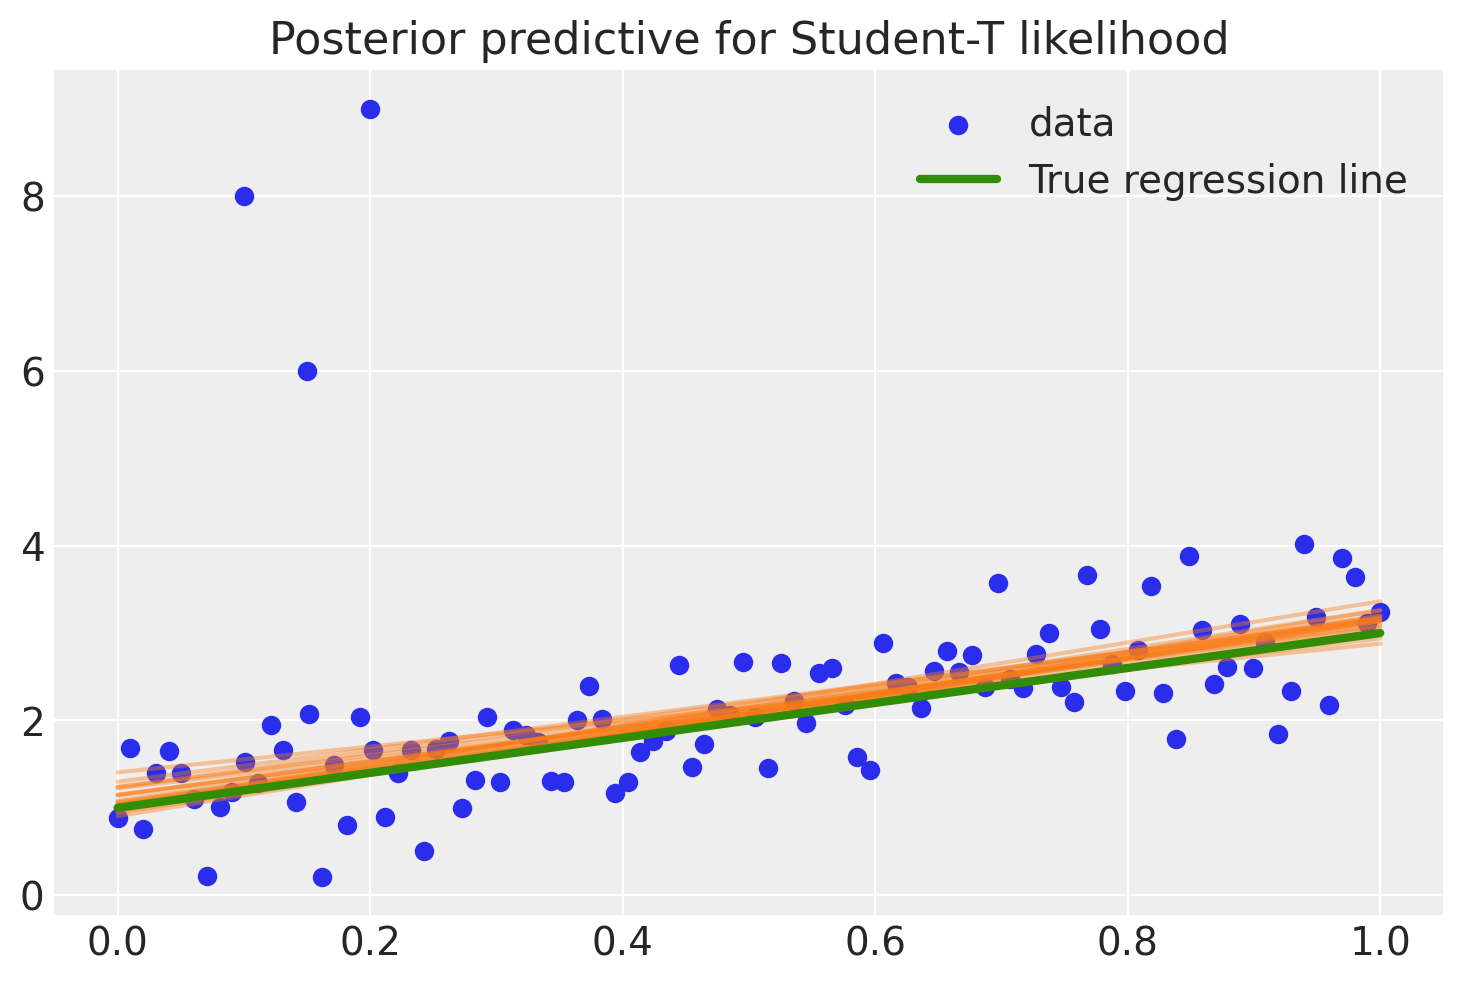

In [31]:
plt.scatter(x_out, y_out, label="data")
plt.plot(x_plot, robust_lines.transpose(), alpha=0.4, color="C1")
plt.plot(x, true_regression_line, label="True regression line", lw=3.0, c="C2")
plt.legend(loc=0)
plt.title("Posterior predictive for Student-T likelihood")